In [1]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Collected job data from Lisa using the following command:
# sacct -a --starttime 2020-01-01 --format=jobid,gid,uid,partition,submit,start,end,elapsedraw,cputimeraw,ncpus,nnodes,nodelist,exitcode,state,timelimit > $HOME/jobdata.csv

# Required packages for processing
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, datetime, pytz
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter
from datetime import date, datetime, time
import calendar

%matplotlib inline

In [2]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Required preprocessing/parsing of the job data
def preprocess_jobdata_to_df(name):
    with open(os.path.join(location_job_data_csv, name),'r') as file:
        filedata = file.read()
        filedata = filedata.replace('None assigned','NoneAssigned')
    with open(os.path.join(location_job_data_csv, str('processed_'+name)),'w') as file:
        file.write(filedata)
    jobdata = pd.read_fwf(os.path.join(location_job_data_csv, str('processed_'+name)), delimiter=r"\s+", header=None)#, low_memory=False)
    jobdata = jobdata.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    jobdata = jobdata.rename(columns=jobdata.iloc[0]).drop(jobdata.index[0])
    jobdata = jobdata.iloc[1:]
    jobdata = jobdata.astype({"ElapsedRaw": int, "CPUTimeRAW": int, "NCPUS": int})
    return(jobdata)

In [3]:
location_job_data_csv = "path to workload"
jobdata = preprocess_jobdata_to_df("jobdata.csv")


In [4]:
print(jobdata.head())

        JobID    GID    UID Partition               Submit  \
2     4174135  49909  50279    normal  2019-12-27T09:09:30   
3     4174136  49909  50279    normal  2019-12-27T09:09:41   
4     4174921  49909  50279    normal  2019-12-27T12:13:55   
5     4174923  49909  50279    normal  2019-12-27T12:14:00   
6  4175534_16  49826  50196    normal  2019-12-27T14:52:15   

                 Start                  End  ElapsedRaw  CPUTimeRAW  NCPUS  \
2  2019-12-27T11:31:11  2020-01-01T11:27:20      431769     6908304     16   
3  2019-12-27T11:31:11  2020-01-01T11:27:20      431769     6908304     16   
4  2019-12-27T14:07:41  2020-01-01T14:03:49      431768     6908288     16   
5  2019-12-27T14:07:42  2020-01-01T14:03:51      431769     6908304     16   
6  2019-12-27T17:29:01  2020-01-01T17:29:03      432002     6912032     16   

  NNode NodeList ExitCode      State   Timelimit  
2     1   r11n14      0:0  COMPLETED  5-00:00:00  
3     1    r14n2      0:0  COMPLETED  5-00:00:00  
4    

In [4]:
# The code in this cell comes from Caspar Greeven at SURFsara 

# Some extra preprocessing required for the job data, e.g. filtering out irrelevant login nodes
filtered_jobs = jobdata[(jobdata["Start"] >= '2019-12-29 23:00:00') & (jobdata["Start"] <= '2020-08-07 21:59:45')]
filtered_jobs = filtered_jobs[(~filtered_jobs["NodeList"].str.contains("None")) & (~filtered_jobs["NodeList"].str.contains("software")) & (~filtered_jobs["NodeList"].str.contains("login"))]

In [5]:
filtered_jobs["dt"] = pd.to_datetime(filtered_jobs['Submit'], utc=False, format="%Y-%m-%dT%H:%M:%S")
filtered_jobs["submit_hour_of_day"] = filtered_jobs["dt"].dt.hour
filtered_jobs["submit_day_of_week"] = filtered_jobs["dt"].apply(lambda x : x.weekday())
filtered_jobs["submit_date"] = filtered_jobs["dt"].dt.date


In [7]:
# series = filtered_jobs.value_counts("submit_hour_of_day", sort=False)
# df = series.to_frame().append(filtered_jobs.groupby("submit_hour_of_day").std())

In [8]:
# std_per_hour = filtered_jobs.value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").std()

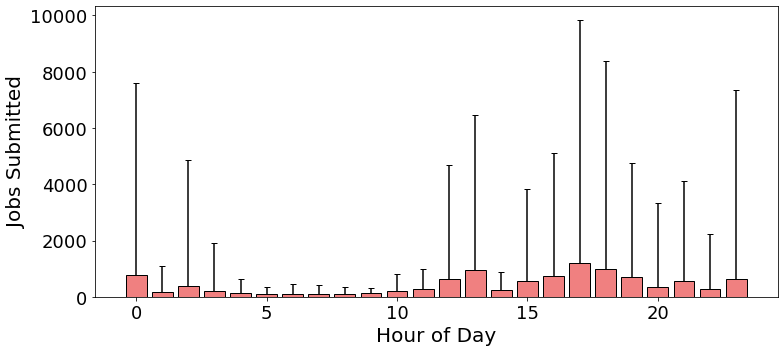

In [9]:
std_per_hour = filtered_jobs.value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").std()
x_vals = np.arange(filtered_jobs["submit_hour_of_day"].nunique())
y_vals = filtered_jobs.value_counts(["submit_date", "submit_hour_of_day"], sort=False).groupby("submit_hour_of_day").mean()

fig, ax = plt.subplots(figsize=(11,5))
negative_direction_values = np.zeros(len(std_per_hour))  # We create a 2d array to make sure matplotlib does not create downwards errorbars
ax.bar(x_vals, y_vals, yerr=[negative_direction_values, std_per_hour], color="lightcoral", edgecolor='black', capsize=3)

# ax.set_xlim(left=-1)
ax.set_ylim(bottom=0, top=None)
ax.set_xlabel("Hour of Day", fontsize=20)
ax.set_ylabel("Jobs Submitted", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

fig.savefig(f"num_jobs_diurnal_hourly_{date_time}.pdf")

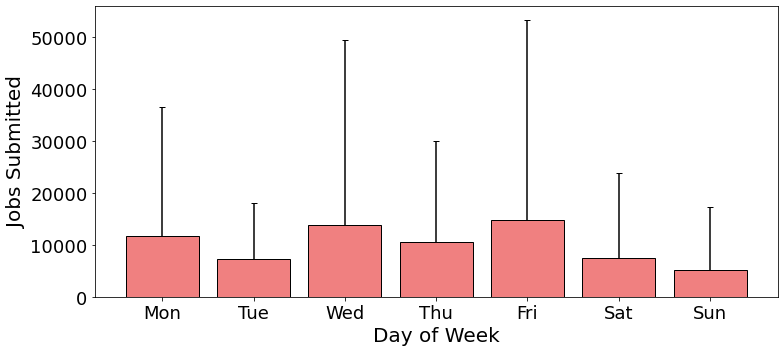

In [6]:
std_per_day_of_week = filtered_jobs.value_counts(["submit_date", "submit_day_of_week"], sort=False).groupby("submit_day_of_week").std()
x_vals = np.arange(filtered_jobs["submit_day_of_week"].nunique())
y_vals = filtered_jobs.value_counts(["submit_date", "submit_day_of_week"], sort=False).groupby("submit_day_of_week").mean()

fig, ax = plt.subplots(figsize=(11,5))
negative_direction_values = np.zeros(len(std_per_day_of_week))  # We create a 2d array to make sure matplotlib does not create downwards errorbars
ax.bar(x_vals, y_vals, yerr=[negative_direction_values, std_per_day_of_week], color="lightcoral", edgecolor='black', capsize=3)

# ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=None)
ax.set_xlabel("Day of Week", fontsize=20)
ax.set_ylabel("Jobs Submitted", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

def get_converted_xticks(ax):
    days_of_week =dict(enumerate(calendar.day_abbr))
    return [days_of_week[tick] for tick in ax.get_xticks()]  # Get the hour number

ax.set_xticks(x_vals)
ax.set_xticklabels(get_converted_xticks(ax))
fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"num_jobs_day_of_week_{date_time}.pdf")

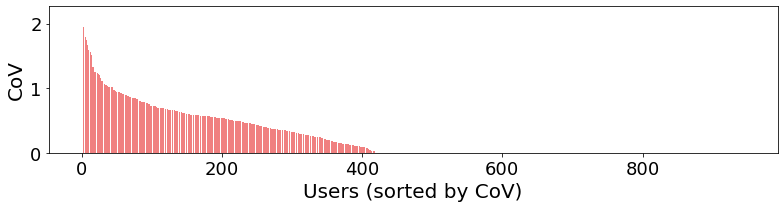

In [11]:
# This cell prints the (sorted) CoV in number of CPUs (cores) requested per user

# cpu_time_per_user = filtered_jobs.groupby("UID")["CPUTimeRAW"].sum()
# data = cpu_time_per_user.sort_values(ascending=False).reset_index()

data = filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).std() / filtered_jobs[["UID", "NCPUS"]].groupby(["UID"]).mean()
data.sort_values("NCPUS", ascending=False, inplace=True)

x_vals = np.arange(len(data))
y_vals = data["NCPUS"]
fig, ax = plt.subplots(figsize=(11,3))
ax.bar(x_vals, y_vals, color="lightcoral")

ax.set_xlabel("Users (sorted by CoV)", fontsize=20)
ax.set_ylabel("CoV", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

fig.tight_layout()

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"cov_cpus_requested_per_user_{date_time}.pdf")

In [12]:
# This cell outputs the total fraction of jobs per state

state_counts_fraction = jobdata["State"].value_counts() / len(jobdata)
state_counts_fraction.rename({"OUT_OF_ME": "OUT OF MEMORY", "NODE_FAIL": "NODE FAILURE"}, inplace=True)

print(r"""\begin{table}[] % Made by running job_arrival_characterization.ipynb
\caption{Fraction of jobs per job state in Lisa}
\label{surfing:tbl:job-state-fraction}
\adjustbox{width=\linewidth}{
\begin{tabular}{@{}llllllllll@{}}""")
print(" & ".join(state_counts_fraction.index))
print(" & ".join(["{:.6f}".format(i) for i in state_counts_fraction.values]))
print(r"""\end{tabular}
}
\end{table}""")

\begin{table}[] % Made by running job_arrival_characterization.ipynb
\caption{Fraction of jobs per job state in Lisa}
\label{surfing:tbl:job-state-fraction}
\adjustbox{width=\linewidth}{
\begin{tabular}{@{}llllllllll@{}}
COMPLETED & FAILED & ANCELLED+ & CANCELLED & TIMEOUT & OUT OF MEMORY & RUNNING & PENDING & REQUEUED & NODE FAILURE
0.860506 & 0.090596 & 0.021809 & 0.014753 & 0.011197 & 0.000631 & 0.000312 & 0.000144 & 0.000048 & 0.000003
\end{tabular}
}
\end{table}


               completed  cancelled     failed  out_of_memory  node_fail  \
type                                                                       
$<$5 minutes    20906469     941884    2279845            0.0        0.0   
$<$1 hour      188182872   10718515   10815368            0.0     4970.0   
$<$6 hours     552998001   40811256   40014691            0.0        0.0   
$<$1 day       771351584  135774303   66325910            0.0        0.0   
$\geq$1 day   1390810962  200480045  165246396            0.0  1050672.0   

                 timeout  
type                      
$<$5 minutes       93846  
$<$1 hour        5603816  
$<$6 hours      60027569  
$<$1 day       172581325  
$\geq$1 day   1078554531  


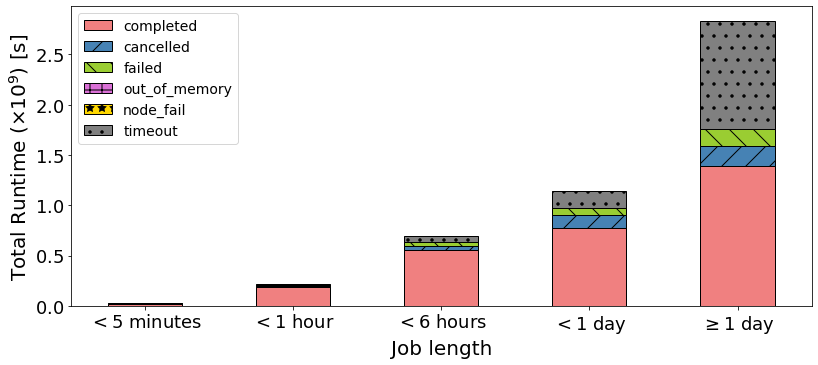

In [13]:
# Kristian's stacked barplot - largely based on his code
def jobType(x):
    if(x < 300):
        return '$<$5 minutes'
    elif(x < 3600):
        return '$<$1 hour'
    elif(x < 21600):
        return '$<$6 hours'
    elif (x < 86100):
        return '$<$1 day'
    else:
        return '$\geq$1 day'

def parsedfsum(df, arg):
    retdf = df[df['State'] == arg]
    retdf = retdf[['ElapsedRaw']]
    retdf['type'] = retdf['ElapsedRaw'].apply(lambda x: jobType(x))
    retdf = retdf.groupby('type').sum()
    retdf.columns = [arg.lower()]
    return retdf

completed = parsedfsum(filtered_jobs, 'COMPLETED')
cancelled = parsedfsum(filtered_jobs, 'CANCELLED')
failed = parsedfsum(filtered_jobs, 'FAILED')
oom = parsedfsum(filtered_jobs, 'OUT_OF_MEMORY')
nodefail = parsedfsum(filtered_jobs, 'NODE_FAIL')
timeout = parsedfsum(filtered_jobs, 'TIMEOUT')

merged = pd.concat([completed,cancelled,failed,oom,nodefail,timeout], axis=1).sort_values('completed', ascending=True)
merged.fillna(0, inplace=True)
print(merged)

colors = ["lightcoral", "steelblue", "yellowgreen", "orchid", "gold", "gray"]
hatches = ['', '/', '\\', '+', '*', '.']


fig, ax = plt.subplots(figsize=(11,5))
ax = merged.plot.bar(stacked=True,
                     fontsize=14,
                     ax=ax,
                     color=colors,
                     edgecolor="black",
                    )


# Based on https://stackoverflow.com/a/22836353
bars = ax.patches
for num, bar in enumerate(bars):
    bar.set_hatch(hatches[int(num / merged.index.nunique())])

ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=True)) 
ax.set_xticklabels(labels=merged.index, rotation=0)
ax.yaxis.get_offset_text().set_visible(False)

fig.tight_layout()  # This forces matplotlib to compute the offset label, which otherwise will be empty. Has no impact on the figure.

ax.set_xlabel('Job length', fontsize=20)
ax.set_ylabel("Total Runtime ({}) [s]".format(ax.get_yaxis().get_major_formatter().get_offset()), fontsize=20)  # Based on https://stackoverflow.com/a/45766598
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(prop={"size": 14})

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig(f"runtime_per_state_grouped_job_runtime_{date_time}.pdf", bbox_inches='tight')